In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as color
import numpy as np

# Problem (1)

Creating environment for dipole; copying Charge class and dipole potential function from Unit 1.

In [54]:
class Charge:
    def __init__(self,x,y,q):
        self.x=x
        self.y=y
        self.q=q
        return
    def potential(self, xgrid, ygrid): 
        dx = xgrid - self.x
        dy = ygrid - self.y
        r = np.sqrt(dx**2 + dy**2)
        return self.q / r 

In [55]:
def dipole_potential(n):
    # Create charges
    charge1 = Charge(18, 25, -1)
    charge2 = Charge(18 + n, 25, +1)

    # Create grid
    x = np.linspace(0, 51, 51)
    y = np.linspace(0, 51, 51)
    xgrid, ygrid = np.meshgrid(x, y)

    # Calculate potential
    V = charge1.potential(xgrid, ygrid) + charge2.potential(xgrid, ygrid)
    return V

Creating function to manually compute gradient

In [56]:
def m_gradient(V, h):
    # Calculate gradient 
    Ex = np.zeros_like(V)
    Ey = np.zeros_like(V)

    # Forward/backward differences for boundaries
    Ey[0, :] = (V[1, :] - V[0, :]) / h 
    Ey[-1, :] = (V[-1, :] - V[-2, :]) / h  
    Ex[:, 0] = (V[:, 1] - V[:, 0]) / h  
    Ex[:, -1] = (V[:, -1] - V[:, -2]) / h  
    
    # Central differences for the rest
    Ey[1:-1, :] = (V[2:, :] - V[:-2, :]) / (2 * h)  
    Ex[:, 1:-1] = (V[:, 2:] - V[:, :-2]) / (2 * h) 
    
    return Ex, Ey


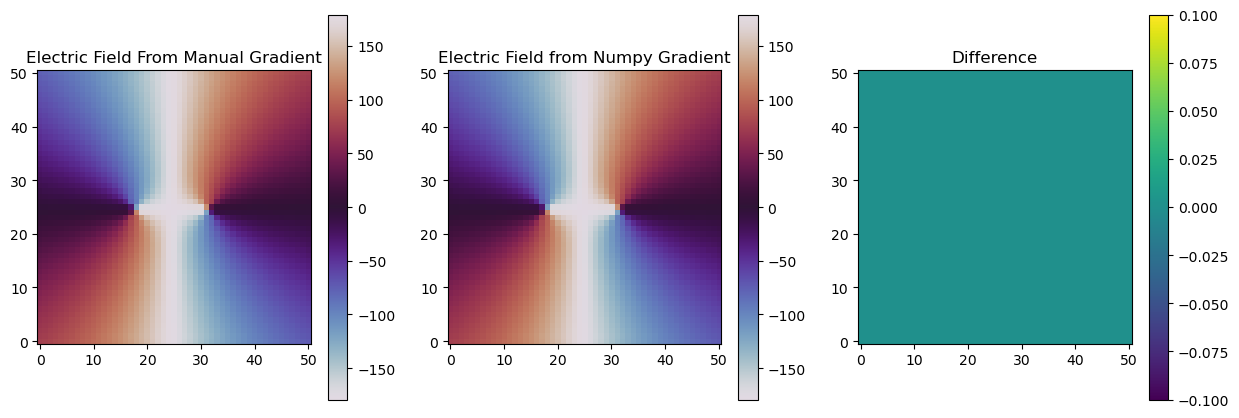

In [57]:
dip = dipole_potential(14)
Ex1, Ey1 = m_gradient(dip, 1)
Exn, Eyn = np.gradient(dip)

# Calculate angle    
angle1 = np.degrees(np.arctan2(-Ey1, -Ex1))
angle2 = np.degrees(np.arctan2(-Exn, -Eyn))
diff = angle1-angle2

fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Plot angle1
g1 = axs[0].imshow(angle1, cmap='twilight', origin='lower')
axs[0].set_title('Electric Field From Manual Gradient')
fig.colorbar(g1, ax=axs[0])

# Plot angle2
g2 = axs[1].imshow(angle2, cmap='twilight', origin='lower')
axs[1].set_title('Electric Field from Numpy Gradient')
fig.colorbar(g2, ax=axs[1])

# Plot difference
g3 = axs[2].imshow(diff, origin='lower')
axs[2].set_title('Difference')
fig.colorbar(g3, ax=axs[2])

plt.show()


This scheme yields the same output as `np.gradient`

# Problem (2)

Create a new function to calculate the electric field.

In [58]:
def e_field(charges, xgrid, ygrid):
    Ex = np.zeros_like(xgrid) 
    Ey = np.zeros_like(ygrid) 

    for charge in charges:
        dx = xgrid - charge.x
        dy = ygrid - charge.y
        r = np.sqrt(dx**2 + dy**2)

        
        # Calculate the contribution to the electric field
        Ex += charge.q * dx / r**3
        Ey += charge.q * dy / r**3
        

    return Ex, Ey


Create a function to generate a dipole, call the electric field function, and calculate angle between $E_x$ and $E_y$.

In [59]:
def dip_field(n):
    # Create dipole charges
    dip_charges = np.array([Charge(18, 25, 1), Charge(18 + n, 25, -1)])
    
    # Create 51 x 51 grid
    x = np.linspace(0, 51, 51)
    y = np.linspace(0, 51, 51)
    xgrid, ygrid = np.meshgrid(x, y)

    Ex, Ey = e_field(dip_charges, xgrid, ygrid)
    angle = np.degrees(np.arctan2(-Ey, -Ex))
    return Ex, Ey, angle

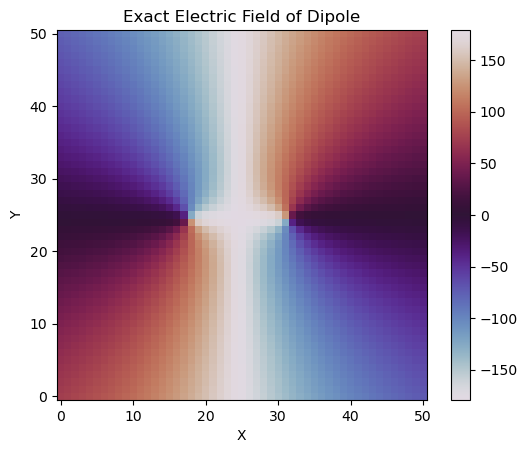

In [60]:
Ex2, Ey2, angle = dip_field(14)

# Plot
plt.imshow(angle, cmap='twilight', origin='lower')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exact Electric Field of Dipole')
plt.show()

Calculating the errors between the exact electric field and the electric field found using the gradient: 

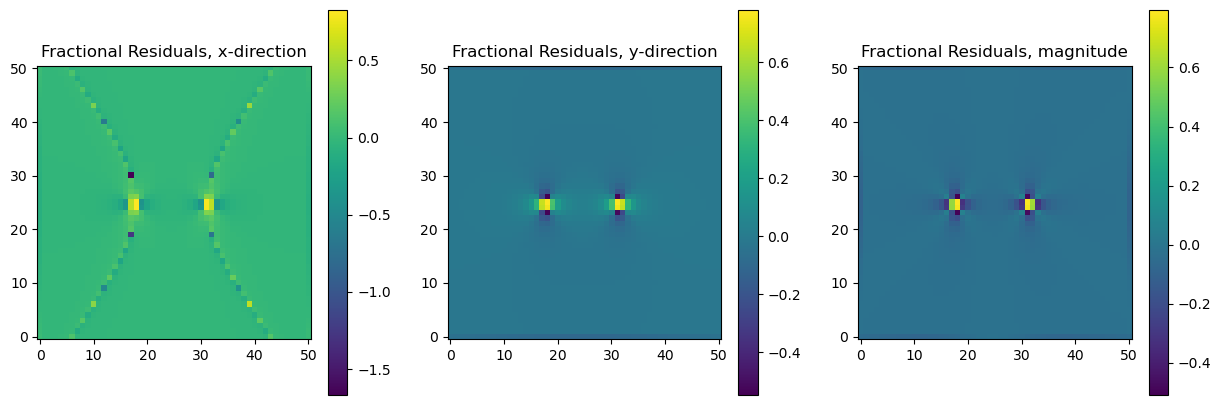

In [61]:
Errx, Erry = (Ex2-Ex1)/Ex2, (Ey2-Ey1)/Ey2
Errmag = (np.hypot(Ex2, Ey2) - np.hypot(Ex1, Ey1))/np.hypot(Ex2, Ey2)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Errx
im1 = axs[0].imshow(Errx, origin='lower')
axs[0].set_title('Fractional Residuals, x-direction')
fig.colorbar(im1, ax=axs[0])

# Plot Erry
im2 = axs[1].imshow(Erry, origin='lower')
axs[1].set_title('Fractional Residuals, y-direction')
fig.colorbar(im2, ax=axs[1])

# Plot Errmag
im3 = axs[2].imshow(Errmag, origin='lower')
axs[2].set_title('Fractional Residuals, magnitude')
fig.colorbar(im3, ax=axs[2])

plt.show()


# Problem (3)

## (A)

Create a function to calculate electric field at a point

In [62]:
def e_fieldp(charges, x, y):
    Ex = 0
    Ey = 0
    for charge in charges:
        dx = x - charge.x
        dy = y - charge.y
        r = np.sqrt(dx**2 + dy**2)

        # Calculate the contribution to the electric field
        Ex += charge.q * dx / r**3
        Ey += charge.q * dy / r**3

    return Ex, Ey


Creating a function for drawing field lines using Euler's method

In [63]:
def field_lines(charges, xi, yi, lim, h=0.1):
    x, y = xi, yi
    trajx, trajy = np.array([]), np.array([])
    neg_charge = charges[1]
    while True:
        Ex, Ey = e_fieldp(charges, x, y)
        Emag = np.hypot(Ex, Ey)
        x += h * Ex/Emag
        y += h * Ey/Emag
        dxneg, dyneg = neg_charge.x - x, neg_charge.y - y
        R = np.hypot(dxneg, dyneg)
        trajx = np.append(trajx, x)
        trajy = np.append(trajy, y) 

        # Wrap around to the right side
        if x < -lim or x > lim or y < -lim or y > lim:
            x = -x
            R = np.hypot(x - neg_charge.x, y - neg_charge.y) 
            continue

        if R < 0.5:
            break
    
    return trajx, trajy


In [82]:
def mplot(dip_pos, lim):
    _, ax = plt.subplots(1,1)
    msize = 100
    ax.scatter(dip_pos[0, 0], dip_pos[1, 0],s=msize, marker='o', color='blue', zorder=2)
    ax.scatter(dip_pos[0, 1], dip_pos[1, 1],s=msize, marker='o', color='red', zorder=2)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_xticks(np.arange(-25, 25, 1), minor=True)
    ax.set_yticks(np.arange(-25, 25, 1), minor=True)
    ax.grid(which='both')
    ax.set_axisbelow(True)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Electric Field Lines of Dipole')
    return ax

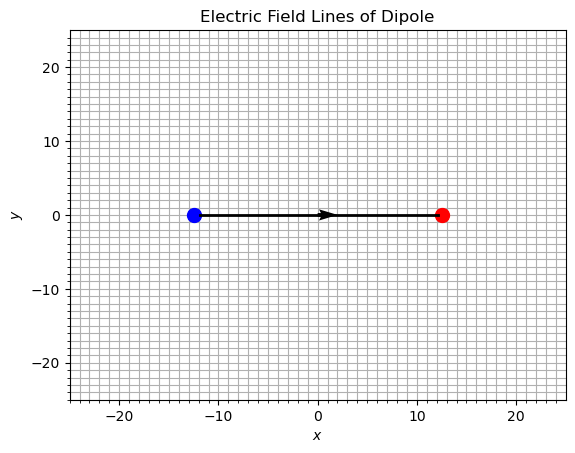

In [83]:
lim = 25
dip_pos = np.array([[-lim/2, lim/2], [0, 0]])
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)])
trajx1, trajy1 = field_lines(dipole, dip_pos[0, 0]+0.5, 0, lim)
ax1 = mplot(dip_pos, lim)
ax1.plot(trajx1, trajy1, "k-", linewidth=2)
ax1.quiver(trajx1[int(len(trajx1)/2-1)], trajy1[int(len(trajy1)/2-1)], trajx1[int(len(trajx1)/2-1)]+0.2, 0, scale=1.0, scale_units='inches')
plt.show()


## (B)

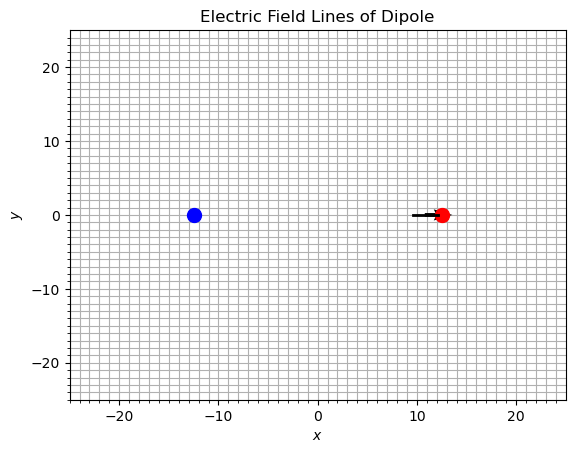

In [84]:
lim = 25
dip_pos = np.array([[-lim/2, lim/2], [0, 0]])
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)])
trajx1, trajy1 = field_lines(dipole, dip_pos[0, 1]-3, dip_pos[1,1], lim)
ax2 = mplot(dip_pos, lim)
ax2.plot(trajx1, trajy1, "k-", linewidth=2)
ax2.quiver(trajx1[int(len(trajx1)/2-1)], trajy1[int(len(trajy1)/2-1)], trajx1[int(len(trajx1)/2-1)] + 0.2, 0)
plt.show()


## (C)

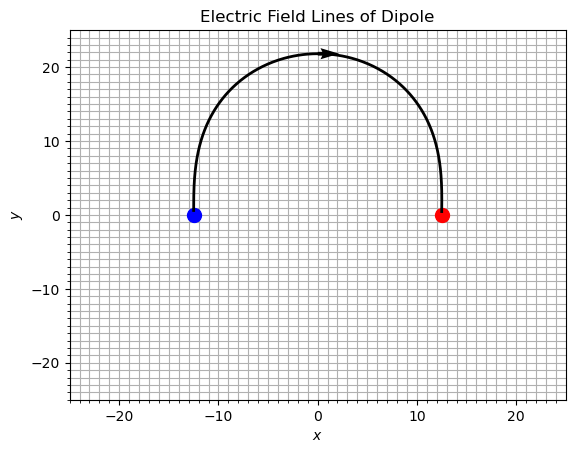

In [85]:
lim = 25
dip_pos = np.array([[-lim/2, lim/2], [0, 0]])
dipole = np.array([Charge(dip_pos[0, 0], dip_pos[1, 0], 1), Charge(dip_pos[0, 1], dip_pos[1, 1], -1)])
trajx1, trajy1 = field_lines(dipole, dip_pos[0, 0], dip_pos[1,0]+0.5, lim)
ax3 = mplot(dip_pos, lim)
ax3.plot(trajx1, trajy1, "k-", linewidth=2)
ax3.quiver(trajx1[int(len(trajx1)/2-1)], trajy1[int(len(trajy1)/2-1)], trajx1[int(len(trajx1)/2-1)] + 0.2, 0, scale=1.0, scale_units='inches')
plt.show()



## (D)

# Problem 4

In [86]:
def eq_points(n, radius, xc, yc):
    xr, yr = np.array([]), np.array([])
    for i in range(n):
        xr, yr = np.append(xr, xc + radius * np.cos((2*np.pi*i)/(n))), np.append(yr, yc + radius * np.sin((2*np.pi*i)/(n)))
    return xr, yr

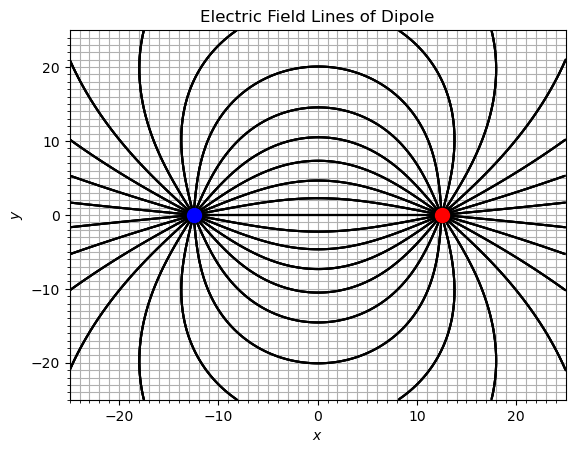

In [87]:
lim = 25
dip_pos = np.array([[-lim/2, lim/2], [0, 0]])
n = 25
xr, yr = eq_points(n, 0.5, -12.5, 0)
ax = mplot(dip_pos, lim)
for i in range(n):
    trajxp, trajyp = field_lines(dipole, xr[i], yr[i], lim)
    for j in range(len(trajxp) - 1):
        if abs(trajxp[j + 1] - trajxp[j]) < lim / 2:
            ax.plot(trajxp[j:j + 2], trajyp[j:j + 2], "k-", zorder=1)

